In [1]:
# XGBoost Classification

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
from collections import Counter

from sklearn import preprocessing, svm
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score

from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
#from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval

In [3]:
columns_new=['Site', 
             'EVI (3 Years Before)', 'NDVI (3 Years Before)', 'FPAR (3 Years Before)', 'LAI (3 Years Before)', 
          'LST Day (3 Years Before)', 'LST Night (3 Years Before)', 'EVI (2 Years Before)', 'NDVI (2 Years Before)', 
          'FPAR (2 Years Before)', 'LAI (2 Years Before)', 'LST Day (2 Years Before)','LST Night (2 Years Before)', 
          'EVI (1 Year Before)', 'NDVI (1 Year Before)', 'FPAR (1 Year Before)', 'LAI (1 Year Before)', 
          'LST Day (1 Year Before)', 'LST Night (1 Year Before)',
       'LATITUDE', 'LONGITUDE', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'Date', '_classes']

In [4]:
variable = [
            'geopotential', 'relative_humidity', 'temperature',
            'u component of wind', 'v component of wind',
        ]
pressure_level = [
             '300', '500', '700', '850']

_columns = []
for i in pressure_level:
    for j in variable:
        _columns.append(i + ': ' + j)

In [5]:
df1 = pd.read_csv("Data/wildfire_classes2.csv").dropna()
df1.columns = columns_new

df_rad = pd.read_csv("wf_era5.csv").dropna().iloc[:, 1:21]
df_rad.columns = _columns

df2 = pd.concat([df1.iloc[:, :-6], df_rad, df1.iloc[:, -6:]], axis = 1)

In [6]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on your data
scaler.fit(df2.iloc[:, 1:-6])

# Transform your DataFrame
scaled_df = scaler.transform(df2.iloc[:, 1:-6])

# Convert the scaled array back to a DataFrame
scaled_df = pd.DataFrame(scaled_df, columns=df2.iloc[:, 1:-6].columns)

In [7]:
scaled_df = pd.concat([df2.iloc[:, :1], df2.iloc[:, 1:-6], df2.iloc[:, -6:]], axis = 1)

In [8]:
df = scaled_df.sample(frac = 1)

In [9]:
df

,Site,EVI (3 Years Before),NDVI (3 Years Before),FPAR (3 Years Before),LAI (3 Years Before),LST Day (3 Years Before),LST Night (3 Years Before),EVI (2 Years Before),NDVI (2 Years Before),FPAR (2 Years Before),...,850: relative_humidity,850: temperature,850: u component of wind,850: v component of wind,LATITUDE,LONGITUDE,FIRE_SIZE,FIRE_SIZE_CLASS,Date,_classes
1493,NOL44,0.134179,0.294790,0.228263,0.964407,-3.936591,2.211574,0.143881,0.305414,0.292836,...,292.259639,3.683220,2.590311,14636.51588,39.220000,-123.333056,3000.00,4,7/3/2008,1
98,GBL46,0.003339,-0.021974,-0.096228,-0.342156,15.384898,4.295221,0.009608,-0.010736,-0.071050,...,300.054173,2.109419,0.195753,14489.58438,39.425056,-112.346912,78065.00,4,6/26/2020,1
389,NRB13,-0.043398,-0.103384,-0.119760,-0.435317,4.536198,1.284564,-0.042060,-0.103586,-0.103312,...,297.118878,-0.917225,0.627123,14697.94294,45.401568,-106.294672,9.70,1,8/24/2017,0
808,NWG24,-0.106929,-0.188832,-0.220064,-0.634952,7.485946,3.793243,-0.101910,-0.172408,-0.209622,...,295.025807,4.627620,-1.807904,14516.61130,46.859700,-119.993300,25000.00,4,7/18/2014,1
1217,SWS14,-0.033791,-0.125458,-0.124696,-0.436342,8.035532,2.384411,-0.040874,-0.133136,-0.148381,...,296.761441,9.898362,0.628803,14013.14528,32.926960,-103.356940,261.00,3,5/25/2011,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,GBG41,-0.023676,-0.052952,-0.062672,-0.189597,5.361256,1.039085,-0.036800,-0.070336,-0.101792,...,297.661553,1.184858,1.097301,14893.28154,40.696400,-117.368000,6409.00,4,7/6/2019,1
455,SWL55,-0.005828,-0.030685,-0.037325,-0.244635,2.917363,4.801492,0.000399,-0.024393,-0.015043,...,302.168998,4.486201,0.451414,14594.29186,32.374167,-110.632500,27259.00,4,6/30/2017,1
1923,SWL2,-0.031392,-0.110032,-0.183690,-0.564974,8.983879,4.526213,-0.034821,-0.115148,-0.192952,...,303.267245,-0.174363,1.989330,14736.35293,35.349400,-114.343000,11927.00,4,7/22/2005,1
670,AKL35,0.026959,0.060697,0.144233,0.393718,-8.127951,1.379431,0.043810,0.094010,0.159715,...,284.271230,10.584726,-4.079376,14925.16474,57.600000,-152.320000,4862.00,4,8/27/2015,1


In [10]:
len(df.index)

2060

In [11]:
xlist = df.columns[1:-4]
ylist = ['_classes']

In [12]:
import xgboost as xgb
X = df.loc[:, xlist]
y = df.loc[:, ylist]

In [13]:
import xgboost as xgb
train_index1 = []
test_index1 = []
train = []
acc = []
feat = []
kf = KFold(n_splits=10, shuffle = True, random_state = 2020)
kf.get_n_splits(X)
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    
    clf = xgb.XGBClassifier(
                            max_depth = 8, n_estimators = 500,
                            learning_rate = 0.1, 
                            random_state = 4040)
                            
    clf.fit(X_train, y_train.values)
    
    train.append(clf.score(X_train, y_train))
    train_index1.append(train_index)
    test_index1.append(test_index)
    
    y_pred = clf.predict(X_test)
    
    #sel = SelectFromModel(clf)
    #sel.fit(X_train, y_train.values.ravel())
    #print(sel.get_support())
    #selected_feat = X_train.columns[(sel.get_support())]
    #feat += selected_feat.values.tolist()
    #print(selected_feat.values)
    
    acc.append(accuracy_score(y_pred , y_test))

print("Test Max ", max(acc))
#print("Corresponding Train ", train[acc.index(max(acc))])
#print("Train Index ", train_index1[acc.index(max(acc))])
#print("Test Index ", test_index1[acc.index(max(acc))])
print("Test Mean ", mean(acc))

Test Max  0.9223300970873787
Test Mean  0.8907766990291263


In [14]:
len(df.index)

2060

In [15]:
acc

[0.9223300970873787,
 0.883495145631068,
 0.8543689320388349,
 0.8495145631067961,
 0.912621359223301,
 0.8883495145631068,
 0.912621359223301,
 0.8932038834951457,
 0.912621359223301,
 0.8786407766990292]

In [16]:
y_pred = clf.predict(X)
accuracy_score(y_pred , y)

0.9878640776699029

In [17]:
y_pred.T

array([1, 1, 0, ..., 1, 1, 0])

In [18]:
y['_classes']

1493    1
98      1
389     0
808     1
1217    0
       ..
185     1
455     1
1923    1
670     1
660     0
Name: _classes, Length: 2060, dtype: int64

In [19]:
len(df.index)

2060

In [20]:
df['y_pred'] = y_pred
#df

In [21]:
df

,Site,EVI (3 Years Before),NDVI (3 Years Before),FPAR (3 Years Before),LAI (3 Years Before),LST Day (3 Years Before),LST Night (3 Years Before),EVI (2 Years Before),NDVI (2 Years Before),FPAR (2 Years Before),...,850: temperature,850: u component of wind,850: v component of wind,LATITUDE,LONGITUDE,FIRE_SIZE,FIRE_SIZE_CLASS,Date,_classes,y_pred
1493,NOL44,0.134179,0.294790,0.228263,0.964407,-3.936591,2.211574,0.143881,0.305414,0.292836,...,3.683220,2.590311,14636.51588,39.220000,-123.333056,3000.00,4,7/3/2008,1,1
98,GBL46,0.003339,-0.021974,-0.096228,-0.342156,15.384898,4.295221,0.009608,-0.010736,-0.071050,...,2.109419,0.195753,14489.58438,39.425056,-112.346912,78065.00,4,6/26/2020,1,1
389,NRB13,-0.043398,-0.103384,-0.119760,-0.435317,4.536198,1.284564,-0.042060,-0.103586,-0.103312,...,-0.917225,0.627123,14697.94294,45.401568,-106.294672,9.70,1,8/24/2017,0,0
808,NWG24,-0.106929,-0.188832,-0.220064,-0.634952,7.485946,3.793243,-0.101910,-0.172408,-0.209622,...,4.627620,-1.807904,14516.61130,46.859700,-119.993300,25000.00,4,7/18/2014,1,1
1217,SWS14,-0.033791,-0.125458,-0.124696,-0.436342,8.035532,2.384411,-0.040874,-0.133136,-0.148381,...,9.898362,0.628803,14013.14528,32.926960,-103.356940,261.00,3,5/25/2011,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,GBG41,-0.023676,-0.052952,-0.062672,-0.189597,5.361256,1.039085,-0.036800,-0.070336,-0.101792,...,1.184858,1.097301,14893.28154,40.696400,-117.368000,6409.00,4,7/6/2019,1,1
455,SWL55,-0.005828,-0.030685,-0.037325,-0.244635,2.917363,4.801492,0.000399,-0.024393,-0.015043,...,4.486201,0.451414,14594.29186,32.374167,-110.632500,27259.00,4,6/30/2017,1,1
1923,SWL2,-0.031392,-0.110032,-0.183690,-0.564974,8.983879,4.526213,-0.034821,-0.115148,-0.192952,...,-0.174363,1.989330,14736.35293,35.349400,-114.343000,11927.00,4,7/22/2005,1,1
670,AKL35,0.026959,0.060697,0.144233,0.393718,-8.127951,1.379431,0.043810,0.094010,0.159715,...,10.584726,-4.079376,14925.16474,57.600000,-152.320000,4862.00,4,8/27/2015,1,1


In [22]:
import sqlite3  
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium


conn = sqlite3.connect('Data/FPA_FOD_20221014.sqlite')
#in lieu of dataframe manipulation in the next code block:
#df = df.query("FIRE_SIZE >= 300")

#df = pd.read_csv("Data/wildfire_classes1.csv").dropna()
bike_station_locations = df[["LATITUDE", "LONGITUDE", "y_pred"]]

In [23]:
m = folium.Map(location=[bike_station_locations.LATITUDE.mean(), bike_station_locations.LONGITUDE.mean()], zoom_start=4, control_scale=True)

In [24]:
lat_interval = 5
lon_interval = 5

for lat in range(20, 80, lat_interval):
     folium.PolyLine([[lat, -180],[lat, -60]], weight=0.5).add_to(m)

for lon in range(-180, -60, lon_interval):
    folium.PolyLine([[20, lon],[80, lon]], weight=0.5).add_to(m)

m

In [25]:
env = pd.read_csv("env.csv", encoding='latin-1').iloc[0:1625, :]

In [26]:
def colorcode(x):
    if x in range(0,1):
        color = 'purple'
    else:
        color = 'red'
    return color

In [27]:
for index, location_info in bike_station_locations.iterrows():
    marker = folium.Circle(location=[location_info["LATITUDE"], location_info["LONGITUDE"]], 
                           radius = 10000, 
                           color = colorcode(int(location_info["y_pred"])), 
                           fill=True, 
                           fill_opacity=0.6,
                           weight = 0.01
                            )
    
    marker.add_to(m)
m.save("map21.html")

In [28]:
for index, location_info1 in env.iterrows():
    folium.Circle(
        location=[location_info1["Latitude"], location_info1["Longitude"]],
        radius = 15000,
        fill=True,
        color = "blue",
        fill_opacity = 0.7,
        weight = 0.01
    ).add_to(m)
#m.save("map5.html")

In [29]:
m

In [30]:
m.save("map21.html")

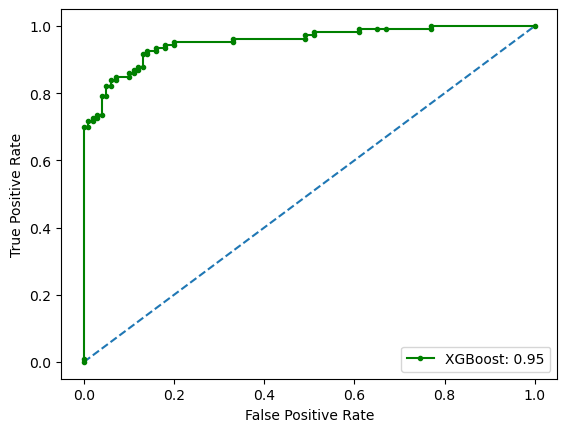

In [31]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='XGBoost: ' + str(lr_auc)[:4], color = 'green')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend(loc = 'lower right')
# show the plot
pyplot.show()

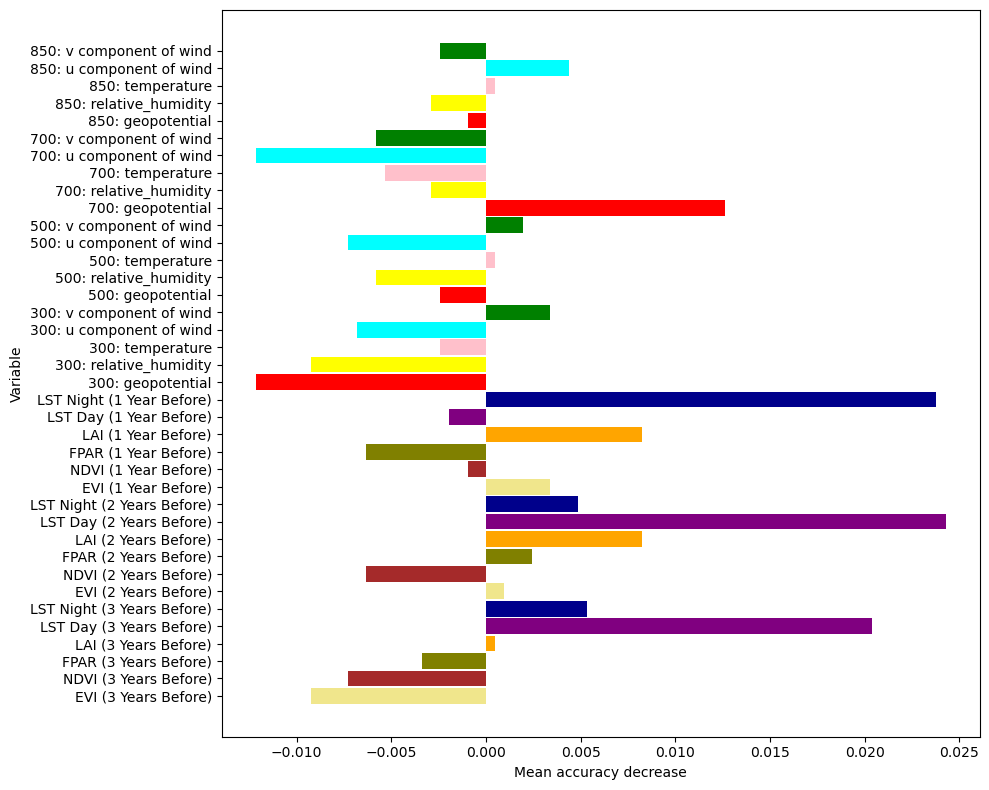

In [32]:
from sklearn.inspection import permutation_importance
colors = ['khaki', 'brown', 'olive', 'orange', 'purple', 'darkblue']*3 + ['red', 'yellow', 'pink', 'cyan', 'green']*5
Labels = xlist[0:-2]

result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean[0:-2], index=Labels)

#fig, ax = plt.subplots()
#ax.barh(Labels, feat_importances, color = colors, height = 0.9)
#ax.set_xlabel('Feature Importance (MDI)')
#ax.set_ylabel('Variable')
#plt.show()

fig, ax = plt.subplots(figsize = (10,8))
ax.barh(Labels, forest_importances, color = colors, height = 0.9)
#forest_importances.plot.barh(yerr=result.importances_std, ax=ax, color = colors)
ax.set_xlabel("Mean accuracy decrease")
ax.set_ylabel("Variable")
fig.tight_layout()
plt.show()

In [33]:
import itertools
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Greens'))
    #plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=12)
    plt.yticks(tick_marks, classes, rotation=90, va='center', ha = 'center', fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center", verticalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black", fontsize=20)

    plt.tight_layout()
    plt.ylabel('True label' , fontsize=12)
    plt.xlabel('Predicted label' , fontsize=12)

    return cnf_matrix

In [34]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
class_names = ["Not Large Wildfire", "Large Wildfire"]

# Plot normalized confusion matrix
plt.figure()
generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [206, 2060]

In [ ]:
df_NO = df[df['Site'].str.contains('NO')]
print(len(df_NO))
print(len(df_NO)/len(df))

import xgboost as xgb
X = df_NO.loc[:, xlist]
y = df_NO.loc[:, ylist]
    
y_pred = clf.predict(X)
print(accuracy_score(y_pred , y))

In [ ]:
df_NW = df[df['Site'].str.contains('NW')]
print(len(df_NW))
print(len(df_NW)/len(df))

import xgboost as xgb
X = df_NW.loc[:, xlist]
y = df_NW.loc[:, ylist]
   
y_pred = clf.predict(X)
print(accuracy_score(y_pred , y))

In [ ]:
df_NR = df[df['Site'].str.contains('NR')]
print(len(df_NR))
print(len(df_NR)/len(df))

import xgboost as xgb
X = df_NR.loc[:, xlist]
y = df_NR.loc[:, ylist]
 
y_pred = clf.predict(X)
print(accuracy_score(y_pred , y))

In [ ]:
df_SW = df[df['Site'].str.contains('SW')]
print(len(df_SW))
print(len(df_SW)/len(df))

import xgboost as xgb
X = df_SW.loc[:, xlist]
y = df_SW.loc[:, ylist]
    
y_pred = clf.predict(X)
print(accuracy_score(y_pred , y))

In [ ]:
df_SA = df[df['Site'].str.contains('SA')]
print(len(df_SA))
print(len(df_SA)/len(df))

import xgboost as xgb
X = df_SA.loc[:, xlist]
y = df_SA.loc[:, ylist]
    
y_pred = clf.predict(X)
print(accuracy_score(y_pred , y))

In [ ]:
df_GB = df[df['Site'].str.contains('GB')]
print(len(df_GB))
print(len(df_GB)/len(df))

import xgboost as xgb
X = df_GB.loc[:, xlist]
y = df_GB.loc[:, ylist]
   
y_pred = clf.predict(X)
print(accuracy_score(y_pred , y))

In [ ]:
df_RM = df[df['Site'].str.contains('RM')]
print(len(df_RM))
print(len(df_RM)/len(df))

import xgboost as xgb
X = df_RM.loc[:, xlist]
y = df_RM.loc[:, ylist]
    
y_pred = clf.predict(X)
print(accuracy_score(y_pred , y))

In [ ]:
df_SO = df[df['Site'].str.contains('SO')]
print(len(df_SO))
print(len(df_SO)/len(df))

import xgboost as xgb
X = df_SO.loc[:, xlist]
y = df_SO.loc[:, ylist]
 
y_pred = clf.predict(X)
print(accuracy_score(y_pred , y))

In [ ]:
df_AK = df[df['Site'].str.contains('AK')]
print(len(df_AK))
print(len(df_AK)/len(df))

import xgboost as xgb
X = df_AK.loc[:, xlist]
y = df_AK.loc[:, ylist]

   
y_pred = clf.predict(X)
print(accuracy_score(y_pred , y))

In [ ]:
df_EA = df[df['Site'].str.contains('EA')]
print(len(df_EA))
print(len(df_EA)/len(df))

import xgboost as xgb
X = df_EA.loc[:, xlist]
y = df_EA.loc[:, ylist]

y_pred = clf.predict(X)
print(accuracy_score(y_pred , y))